In [ ]:
!pip install qrcode kagglehub albumentations --quiet


In [ ]:
# !pip install -q git+https://github.com/aleju/imgaug.git


In [ ]:

import os
import cv2
import qrcode
import kagglehub
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim



In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cuda


In [ ]:

path = kagglehub.dataset_download("nih-chest-xrays/data")

csv_path = os.path.join(path, "Data_Entry_2017.csv")
images_dir = os.path.join(path, "images")


100%|██████████| 42.0G/42.0G [32:55<00:00, 22.8MB/s]

Extracting files...


In [ ]:
print("KaggleHub yükleme dizini:", path)

KaggleHub yükleme dizini: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [ ]:

print("İçindekiler:", os.listdir(path))


İçindekiler: ['FAQ_CHESTXRAY.pdf', 'images_006', 'LOG_CHESTXRAY.pdf', 'images_002', 'images_005', 'ARXIV_V5_CHESTXRAY.pdf', 'images_009', 'images_003', 'images_001', 'images_004', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_008', 'images_010', 'test_list.txt', 'images_011', 'Data_Entry_2017.csv', 'train_val_list.txt', 'images_007', 'images_012']


In [ ]:
!ls -l /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


total 19348
-rw-r--r-- 1 root root 8963138 May 11 15:49 ARXIV_V5_CHESTXRAY.pdf
-rw-r--r-- 1 root root   92416 May 11 15:49 BBox_List_2017.csv
-rw-r--r-- 1 root root 7861152 May 11 15:49 Data_Entry_2017.csv
-rw-r--r-- 1 root root   72223 May 11 15:49 FAQ_CHESTXRAY.pdf
drwxr-xr-x 3 root root    4096 May 11 15:49 images_001
drwxr-xr-x 3 root root    4096 May 11 15:49 images_002
drwxr-xr-x 3 root root    4096 May 11 15:49 images_003
drwxr-xr-x 3 root root    4096 May 11 15:49 images_004
drwxr-xr-x 3 root root    4096 May 11 15:50 images_005
drwxr-xr-x 3 root root    4096 May 11 15:50 images_006
drwxr-xr-x 3 root root    4096 May 11 15:51 images_007
drwxr-xr-x 3 root root    4096 May 11 15:51 images_008
drwxr-xr-x 3 root root    4096 May 11 15:51 images_009
drwxr-xr-x 3 root root    4096 May 11 15:52 images_010
drwxr-xr-x 3 root root    4096 May 11 15:52 images_011
drwxr-xr-x 3 root root    4096 May 11 15:53 images_012
-rw-r--r-- 1 root root    3919 May 11 15:49 LOG_CHESTXRAY.pdf
-rw-r--r--

In [ ]:
images_dir = os.path.join(path, "images_001")

example_path = os.path.join(images_dir, "images/00000001_000.png")
print("Örnek dosya yolu:", example_path)
print("Var mı?", os.path.exists(example_path))


Örnek dosya yolu: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3/images_001/images/00000001_000.png
Var mı? True


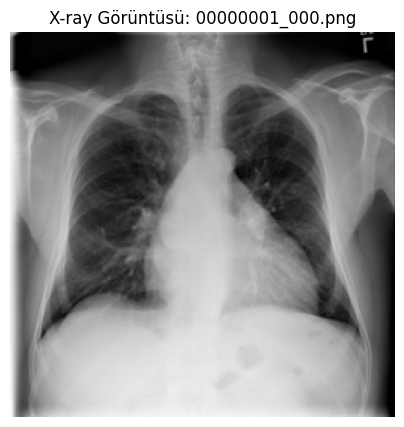

In [ ]:

image_path = "/root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3/images_001/images/00000001_000.png"


xray_image = Image.open(image_path).convert("L").resize((256, 256))


plt.figure(figsize=(5, 5))
plt.imshow(xray_image, cmap="gray")
plt.title("X-ray Görüntüsü: 00000001_000.png")
plt.axis("off")
plt.show()

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
def find_image_path(image_name):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path) and folder.startswith("images"):
            candidate = os.path.join(folder_path, image_name)
            if os.path.exists(candidate):
                return candidate
            nested = os.path.join(folder_path, "images", image_name)
            if os.path.exists(nested):
                return nested
    return None


In [ ]:
df = df[df["Image Index"].apply(lambda x: find_image_path(x) is not None)].reset_index(drop=True)

print("Geçerli görüntü sayısı:", len(df))


Geçerli görüntü sayısı: 112120


In [ ]:

df = pd.read_csv(csv_path)

df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [ ]:



def create_patient_qr(row):
    info = (
        f"Image Index: {row['Image Index']}\n"
        f"Finding Labels: {row['Finding Labels']}\n"
        f"Patient ID: {row['Patient ID']}\n"
        f"Age: {row['Patient Age']}\n"
        f"Gender: {row['Patient Gender']}\n"
        f"View Position: {row['View Position']}"
    )
    qr = qrcode.make(info)
    return qr.convert("L"), info  # grayscale


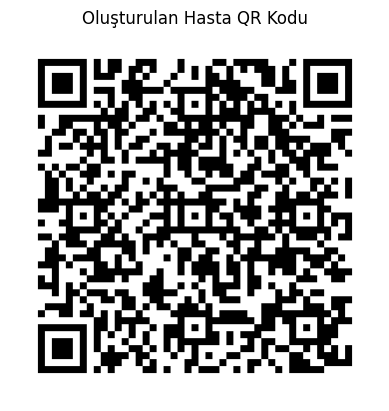

In [ ]:
# test için

sample_row = df.sample(1, random_state=42).iloc[0]


qr_image, qr_text = create_patient_qr(sample_row)

plt.imshow(qr_image, cmap='gray')
plt.axis('off')
plt.title("Oluşturulan Hasta QR Kodu")
plt.show()

In [ ]:
def prepare_input(image_name, qr_img, image_size=256, qr_size=64):
    image_path = find_image_path(image_name)
    if image_path is None:
        raise FileNotFoundError(f"Görüntü bulunamadı: {image_name}")

    image = Image.open(image_path).convert("L").resize((image_size, image_size))
    qr_resized = qr_img.convert("L").resize((qr_size, qr_size))

    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(image)
    qr_tensor = to_tensor(qr_resized)

    return image_tensor.unsqueeze(0), qr_tensor.unsqueeze(0)


In [ ]:



class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


In [ ]:


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            ResnetBlock(64),
            ResnetBlock(64),
            nn.Conv2d(64, 1, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def forward(self, x, qr):
        combined = torch.cat([x, F.interpolate(qr, size=(256,256))], dim=1)
        return self.model(combined)


In [ ]:



class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # [1, 256, 256] -> [64, 256, 256]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # [128, 256, 256]
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), # [64, 256, 256]
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)               # [1, 256, 256]
        )

    def forward(self, x):
        out = self.model(x)
        return F.interpolate(out, size=(64, 64), mode="bilinear", align_corners=False)



In [ ]:



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:


encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)


mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

opt_E_Dec = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
opt_Dis = torch.optim.Adam(discriminator.parameters(), lr=1e-4)



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = df.head(10000)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("Eğitim:", len(df_train), "| Test:", len(df_test))

Eğitim: 8000 | Test: 2000


In [ ]:
epochs = 5

for epoch in range(epochs):
    total_adv_loss, total_rec_loss, total_dis_loss = 0, 0, 0

    for i in range(len(df_train)):
        try:
            row = df_train.iloc[i]
            qr_img, _ = create_patient_qr(row)
            image, qr = prepare_input(row["Image Index"], qr_img)

            image = image.to(device)
            qr = qr.to(device)

            # 1. Discriminator
            wm = encoder(image, qr).detach()
            real_out = discriminator(image).to(device)
            fake_out = discriminator(wm).to(device)

            real_labels = torch.ones_like(real_out)
            fake_labels = torch.zeros_like(fake_out)

            loss_real = bce_loss(real_out, real_labels)
            loss_fake = bce_loss(fake_out, fake_labels)
            loss_dis = (loss_real + loss_fake) / 2

            opt_Dis.zero_grad()
            loss_dis.backward()
            opt_Dis.step()

            # 2. Encoder + Decoder
            wm = encoder(image, qr)
            decoded = decoder(wm)
            adv_out = discriminator(wm)
            real_labels = torch.ones_like(adv_out).to(device)

            adv_loss = bce_loss(adv_out, real_labels)
            rec_loss = mse_loss(decoded, qr)
            total_loss = adv_loss + rec_loss

            opt_E_Dec.zero_grad()
            total_loss.backward()
            opt_E_Dec.step()

            total_adv_loss += adv_loss.item()
            total_rec_loss += rec_loss.item()
            total_dis_loss += loss_dis.item()

            if i % 10 == 0:
                print(f"Epoch {epoch+1} | Index {i} | Adv: {adv_loss.item():.4f} | Rec: {rec_loss.item():.4f} | Dis: {loss_dis.item():.4f}")

        except Exception as e:
            print(f"Hata (Index {i}): {e}")
            continue

    print(f"[Epoch {epoch+1}] Adv: {total_adv_loss/len(df_train):.4f}, Rec: {total_rec_loss/len(df_train):.4f}, Dis: {total_dis_loss/len(df_train):.4f}")


Epoch 1 | Index 0 | Adv: 0.6427 | Rec: 0.4252 | Dis: 0.7164
Epoch 1 | Index 10 | Adv: 0.8731 | Rec: 0.1416 | Dis: 0.6299
Epoch 1 | Index 20 | Adv: 0.9186 | Rec: 0.0892 | Dis: 0.5816
Epoch 1 | Index 30 | Adv: 0.9205 | Rec: 0.0540 | Dis: 0.5504
Epoch 1 | Index 40 | Adv: 0.9553 | Rec: 0.0393 | Dis: 0.5299
Epoch 1 | Index 50 | Adv: 0.9433 | Rec: 0.0591 | Dis: 0.5271
Epoch 1 | Index 60 | Adv: 0.6692 | Rec: 0.1182 | Dis: 0.6800
Epoch 1 | Index 70 | Adv: 0.7080 | Rec: 0.1275 | Dis: 0.6696
Epoch 1 | Index 80 | Adv: 0.7961 | Rec: 0.1265 | Dis: 0.5947
Epoch 1 | Index 90 | Adv: 0.7464 | Rec: 0.0797 | Dis: 0.5594
Epoch 1 | Index 100 | Adv: 0.8797 | Rec: 0.0713 | Dis: 0.5405
Epoch 1 | Index 110 | Adv: 0.9148 | Rec: 0.0825 | Dis: 0.4977
Epoch 1 | Index 120 | Adv: 1.0016 | Rec: 0.1068 | Dis: 0.6760
Epoch 1 | Index 130 | Adv: 0.9117 | Rec: 0.0949 | Dis: 0.6588
Epoch 1 | Index 140 | Adv: 0.9864 | Rec: 0.0867 | Dis: 0.5225
Epoch 1 | Index 150 | Adv: 0.9231 | Rec: 0.1175 | Dis: 0.5043
Epoch 1 | Index 160

In [ ]:


def evaluate_metrics(img1, img2):
    a = img1.squeeze().detach().numpy()
    b = img2.squeeze().detach().numpy()
    return {
        "PSNR": psnr(a, b, data_range=1.0),
        "SSIM": ssim(a, b, data_range=1.0)
    }



In [ ]:
encoder.eval()
decoder.eval()

total_psnr, total_ssim = 0, 0

for i in range(len(df_test)):
    try:
        row = df_test.iloc[i]
        qr_img, _ = create_patient_qr(row)
        image, qr = prepare_input(row["Image Index"], qr_img)

        image = image.to(device)
        qr = qr.to(device)

        with torch.no_grad():
            wm = encoder(image, qr)
            decoded = decoder(wm)

        decoded_cpu = decoded.cpu()
        qr_cpu = qr.cpu()


        metrics = evaluate_metrics(qr_cpu, decoded_cpu)
        total_psnr += metrics["PSNR"]
        total_ssim += metrics["SSIM"]

    except Exception as e:
        print(f"Test örneği atlandı (Index {i}): {e}")
        continue

avg_psnr = total_psnr / len(df_test)
avg_ssim = total_ssim / len(df_test)

print(f"TEST BAŞARISI (10000 veri → %20 test):")
print(f"PSNR ortalama: {avg_psnr:.2f} dB")
print(f"SSIM ortalama: {avg_ssim:.4f}")


TEST BAŞARISI (10000 veri → %20 test):
PSNR ortalama: 19.43 dB
SSIM ortalama: 0.9451


In [ ]:
# Görselleştirmek için


def visualize_all(x, wm, decoded_qr):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x.squeeze().cpu().numpy(), cmap="gray")
    axs[0].set_title("Original")
    axs[1].imshow(wm.squeeze().detach().cpu().numpy(), cmap="gray")
    axs[1].set_title("Watermarked")
    axs[2].imshow(decoded_qr.squeeze().detach().cpu().numpy(), cmap="gray")
    axs[2].set_title("Decoded QR")
    for ax in axs:
        ax.axis("off")
    plt.show()

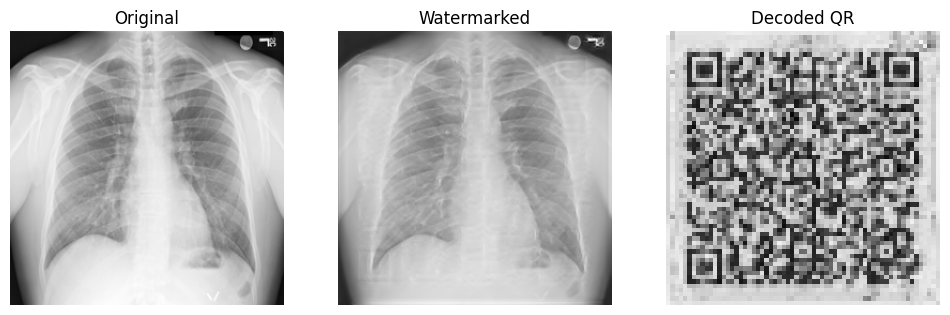

In [ ]:
row = df_test.iloc[10]
qr_img, _ = create_patient_qr(row)


if isinstance(qr_img, np.ndarray):
    qr_img = Image.fromarray((qr_img * 255).astype(np.uint8))  # normalize edilmiş array → grayscale image


image, qr = prepare_input(row["Image Index"], qr_img)


image = image.to(device)
qr = qr.to(device)


wm = encoder(image, qr)
decoded = decoder(wm)

# Tüm çıktı....
visualize_all(image, wm, decoded)

In [ ]:

row = df.sample(1, random_state=42).iloc[0]
qr_img, _ = create_patient_qr(row)
x, qr = prepare_input(row["Image Index"], qr_img)


x = x.to(device)
qr = qr.to(device)

encoder.eval()
decoder.eval()


with torch.no_grad():
    watermarked = encoder(x, qr)
    decoded = decoder(watermarked)


noisy_wm = add_noise(watermarked)
with torch.no_grad():
    decoded_noisy = decoder(noisy_wm)


decoded = decoded.cpu()
decoded_noisy = decoded_noisy.cpu()
qr_cpu = qr.cpu()

metrics_clean = evaluate_metrics(qr_cpu, decoded)
metrics_noisy = evaluate_metrics(qr_cpu, decoded_noisy)

print("QR Çözümleme Başarısı (Temiz):")
for k, v in metrics_clean.items():
    print(f"{k}: {v:.4f}")

print("\nQR Çözümleme Başarısı (Gürültülü Filigran):")
for k, v in metrics_noisy.items():
    print(f"{k}: {v:.4f}")


QR Çözümleme Başarısı (Temiz):
MSE: 0.0152
PSNR: 18.1794
SSIM: 0.9334

QR Çözümleme Başarısı (Gürültülü Filigran):
MSE: 0.2740
PSNR: 5.6222
SSIM: 0.0772


In [ ]:
!apt-get update


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,720 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packa

In [ ]:
!apt-get install -y libzbar0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-double3
  libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libjxr-tools libjxr0
  liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libv4l-0 libv4lconvert0 libwmflite-0.2-7 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x libfftw3-bin libfftw3-dev inkscape poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-

In [ ]:
import numpy as np
import cv2
import qrcode
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import pandas as pd


def create_patient_qr(row):
    info = (
        f"Image Index: {row['Image Index']}\n"
        f"Finding Labels: {row['Finding Labels']}\n"
        f"Patient ID: {row['Patient ID']}\n"
        f"Age: {row['Patient Age']}\n"
        f"Gender: {row['Patient Gender']}\n"
        f"View Position: {row['View Position']}"
    )
    qr = qrcode.make(info)
    qr_np = np.array(qr.convert("L")) / 255.0  # grayscale ve normalize
    return qr_np, info


def apply_attacks(image):
    attacks = {}

    # Gaussian Noise
    noise = np.random.normal(0, 0.05, image.shape)
    attacks['Gaussian Noise'] = np.clip(image + noise, 0, 1)

    # JPEG Compression
    _, encimg = cv2.imencode('.jpg', (image * 255).astype(np.uint8), [int(cv2.IMWRITE_JPEG_QUALITY), 50])
    attacks['JPEG Compression'] = cv2.imdecode(encimg, 0) / 255.0

    # Gaussian Blur
    attacks['Gaussian Blur'] = cv2.GaussianBlur(image, (5, 5), 0)

    # Cropping
    crop = image.copy()
    h, w = crop.shape
    crop[h//4:h//4*3, w//4:w//4*3] = 0
    attacks['Cropping'] = crop

    # Salt & Pepper Noise
    s_p = image.copy()
    prob = 0.02
    rnd = np.random.rand(*s_p.shape)
    s_p[rnd < prob] = 0
    s_p[rnd > 1 - prob] = 1
    attacks['Salt & Pepper'] = s_p

    return attacks


def decode_qr_from_array_opencv(qr_array):
    detector = cv2.QRCodeDetector()
    qr_img = (qr_array * 255).astype(np.uint8)
    value, _, _ = detector.detectAndDecode(qr_img)
    return value if value else None


def evaluate_attack(original, attacked):
    results = []
    for name, img in attacked.items():
        p = psnr(original, img, data_range=1.0)
        s = ssim(original, img, data_range=1.0)
        decoded = decode_qr_from_array_opencv(img)
        qr_ok = decoded is not None and len(decoded.strip()) > 0
        results.append((name, img, p, s, qr_ok))
    return results


qr_data = {
    'Image Index': '00000001_000.png',
    'Finding Labels': 'No Finding',
    'Patient ID': 'P00001',
    'Patient Age': 45,
    'Patient Gender': 'M',
    'View Position': 'PA'
}


qr_img, qr_text = create_patient_qr(qr_data)
attacked_versions = apply_attacks(qr_img)
results = evaluate_attack(qr_img, attacked_versions)


In [ ]:
qr_data = {
    'Image Index': '00000001_000.png',
    'Finding Labels': 'No Finding',
    'Patient ID': 'P00001',
    'Patient Age': 45,
    'Patient Gender': 'M',
    'View Position': 'PA'
}

qr_img, text = create_patient_qr(qr_data)
attacked = apply_attacks(qr_img)
results_df = evaluate_attack(qr_img, attacked)
print(results_df)


             Attack   PSNR   SSIM  QR Decoded
0    Gaussian Noise  29.03  0.659        True
1  JPEG Compression  36.43  0.950        True
2     Gaussian Blur  18.18  0.781        True
3          Cropping   9.06  0.800       False
4     Salt & Pepper  17.04  0.627       False


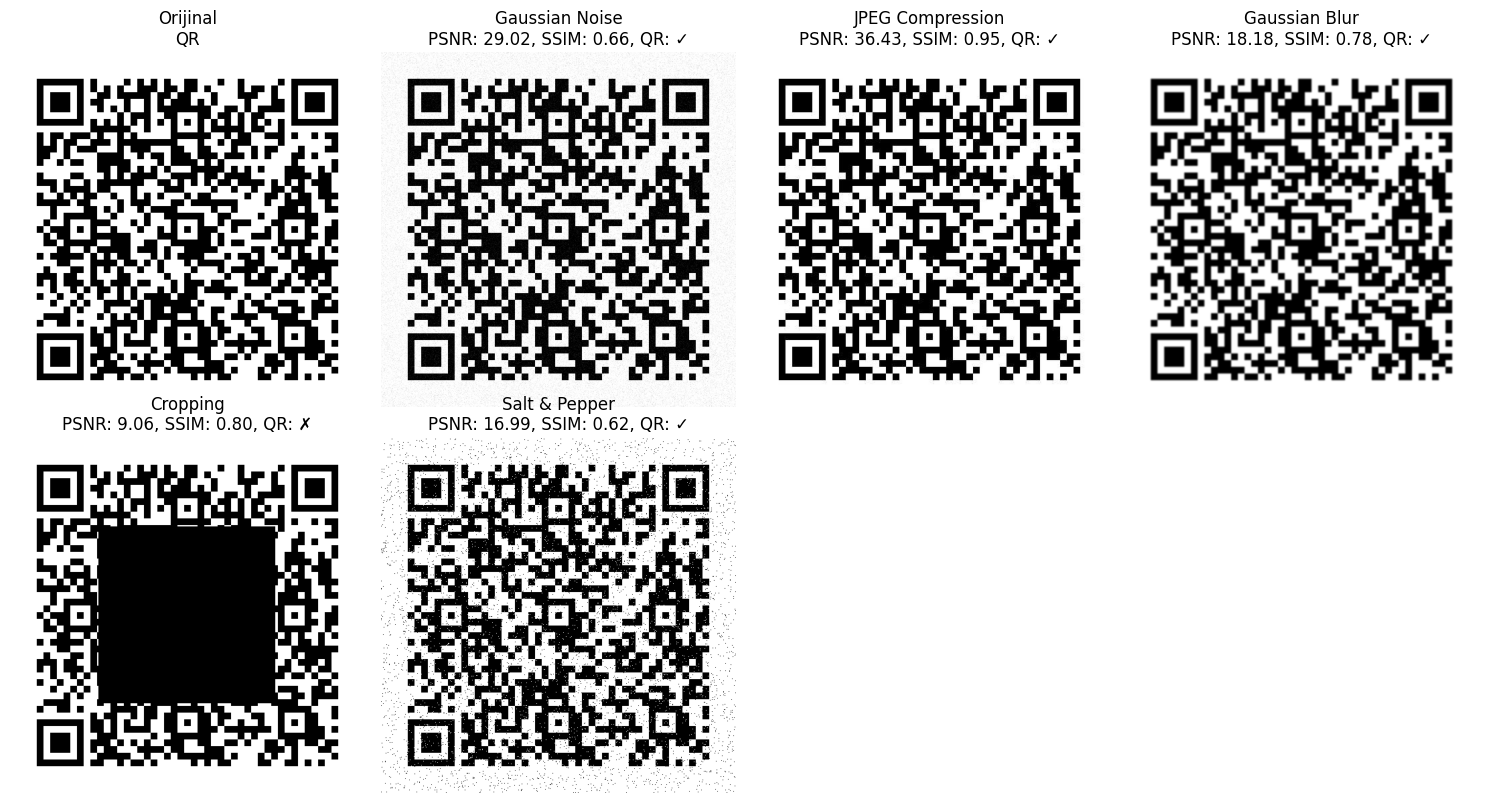

In [ ]:
# 7. Görselleştirme
plt.figure(figsize=(15, 8))
plt.subplot(2, 4, 1)
plt.imshow(qr_img, cmap='gray')
plt.title("Orijinal\nQR")
plt.axis('off')

for i, (name, img, p, s, ok) in enumerate(results):
    plt.subplot(2, 4, i + 2)
    plt.imshow(img, cmap='gray')
    status = "✓" if ok else "✗"
    plt.title(f"{name}\nPSNR: {p:.2f}, SSIM: {s:.2f}, QR: {status}")
    plt.axis('off')

plt.tight_layout()
plt.show()